In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

### This is a playground!

Here you can quickly test some code, visualize your data

In [56]:
import torch
import torch.optim as optim
import torch.nn as nn
from Project import Project
from data.DetectionDataset import DetectionDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from utils import device
import numpy as np
device

'cuda'

In [ ]:
def xywh_to_xyxy(xywh):
    """Convert [x1 y1 w h] box format to [x1 y1 x2 y2] format."""
    if isinstance(xywh, (list, tuple)):
        # Single box given as a list of coordinates
        assert len(xywh) == 4
        x1, y1 = xywh[0], xywh[1]
        x2 = x1 + np.maximum(0., xywh[2] - 1.)
        y2 = y1 + np.maximum(0., xywh[3] - 1.)
        return (x1, y1, x2, y2)
    elif isinstance(xywh, np.ndarray):
        # Multiple boxes given as a 2D ndarray
        return np.hstack(
            (xywh[:, 0:2], xywh[:, 0:2] + np.maximum(0, xywh[:, 2:4] - 1))
        )
    else:
        raise TypeError('Argument xywh must be a list, tuple, or numpy array.')


In [123]:
pr = Project()

yoda_dir = pr.data_dir / 'yoda'

annotations_path = list(yoda_dir.glob('*.txt'))
annotations_path.sort()
images_path = list(yoda_dir.glob('*.jpg'))
images_path.sort()

class ImgBBoxsTr():
    def __init__(self):
        self.to_tensor = ToTensor()
        
    def __call__(self, x, bboxs):
        x = self.to_tensor(x).float()
        bboxs = torch.Tensor(bboxs)
        bboxs_conv = []
        height, width = x.shape[1:]
        for box in bboxs:
            x1, y1, w, h = box
            x1 *= width
            y1 *= height
            w *= width
            h *= height
            bboxs_conv.append(xywh_to_xyxy([x1, y1, w, h]))

        return x, torch.Tensor(bboxs_conv)

In [124]:
# xywh_to_xyxy(ds[0][1]['boxes'].numpy())

In [125]:
ds = DetectionDataset(images_path, annotations_path, transform=ImgBBoxsTr())

ds[1]

(tensor([[[0.0549, 0.0549, 0.0549,  ..., 0.1647, 0.1569, 0.1569],
          [0.0549, 0.0549, 0.0549,  ..., 0.1686, 0.1569, 0.1569],
          [0.0549, 0.0549, 0.0549,  ..., 0.1647, 0.1569, 0.1529],
          ...,
          [0.0471, 0.0471, 0.0471,  ..., 0.1490, 0.1490, 0.1490],
          [0.0471, 0.0471, 0.0471,  ..., 0.1490, 0.1490, 0.1490],
          [0.0471, 0.0471, 0.0471,  ..., 0.1490, 0.1490, 0.1490]],
 
         [[0.0471, 0.0471, 0.0471,  ..., 0.1255, 0.1176, 0.1176],
          [0.0471, 0.0471, 0.0471,  ..., 0.1294, 0.1176, 0.1176],
          [0.0471, 0.0471, 0.0471,  ..., 0.1255, 0.1176, 0.1137],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 0.1098, 0.1098, 0.1098],
          [0.0235, 0.0235, 0.0235,  ..., 0.1098, 0.1098, 0.1098],
          [0.0235, 0.0235, 0.0235,  ..., 0.1098, 0.1098, 0.1098]],
 
         [[0.0510, 0.0510, 0.0510,  ..., 0.1176, 0.1098, 0.1098],
          [0.0510, 0.0510, 0.0510,  ..., 0.1216, 0.1098, 0.1098],
          [0.0510, 0.0510, 0.0510,  ...,

## Show input

In [121]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib notebook

360 640


<IPython.core.display.Javascript object>


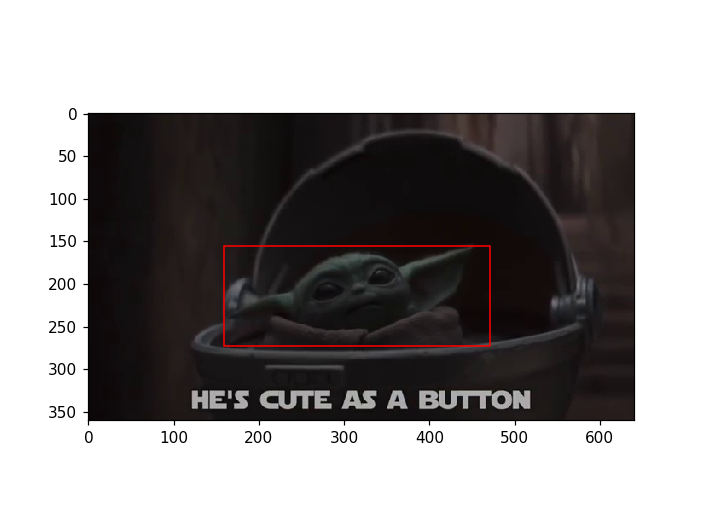

In [122]:
img, target = ds[1]
boxes = target['boxes']
height, width = img.shape[1:]
print(height, width)

fig,ax = plt.subplots(1)

plt.imshow(img.permute(1,2,0).numpy())

for box in boxes:
    box = box.numpy()
    x1, y1, w, h = box
    # we need to convert them to bottom, left, width, height not scaled
#     x1 *= width
#     y1 *= height
#     w *= width
#     h *= height
    
    rect = Rectangle((x1 - w // 2, y1 - h // 2),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)


In [128]:
dl = DataLoader(ds, batch_size=8, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

## Model

In [146]:
from torchvision.models.detection.faster_rcnn  import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(num_classes=2).to(device)


## Training

In [147]:
# https://github.com/pytorch/vision/blob/master/references/detection/engine.py
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [148]:
for i in range(5):

    for images, targets in dl:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(losses)

tensor(1.4082, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1860, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0948, device='cuda:0', grad_fn=<AddBack

In [157]:
model = model.eval()
with torch.no_grad():
    model = model.cuda()
    pred = model([ds[1][0].cuda()])

In [158]:
pred

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0')}]